# gRPC stac-client-python

## What is this Good for
Use this library to query for Near Space Labs aerial imagery by area of interest, date observed and other details. You can also use this library and your credentials to download Near Space Labs Geotiffs and Thumbnails for every scene we've collected. This client accesses [Near Space Labs](https://nearspacelabs.com)' gRPC STAC service (or any gRPC STAC service) for metadata queries. The best way to get familiar with the Near Space Labs client is to pip install the `nsl.stac` package and use the [Jupyter Notebooks provided](#running-included-jupyter-notebooks) (README.ipynb, Examples.ipynb, StacItem.ipynb).

To get access to our high resolution Austin, Texas imagery, get a client id and secret [here](https://www.nearspacelabs.com/#nearspacelabs).

## Sections
- [Setup](#setup)
- [First Code Example](#first-code-example)
- [STAC metadata structure](#what-are-protobufs-grpc-and-spatio-temporal-asset-catalogs)
  - [Assets](#assets-images-to-download)
  - [Stac Item In Depth](./StacItem.md)
- [Queries](#queries)
  - [Simple](#simple-query-and-the-makeup-of-a-stacitem)
  - [Spatial](#spatial-queries)
  - [Temporal](#temporal-queries)
  - [Advanced Examples](./AdvancedExamples.md)
- [Downloading](#downloading)
  - [Thumbnails](#thumbnails)
  - [Geotiffs](#geotiffs)
  - [Handling Deadlines](#handling-deadlines)
- [gRPC STAC vs REST STAC](#differences-between-grpcprotobuf-stac-and-openapijson-stac)

## Setup
**WARNING** You'll need to have Python3 installed (nsl.stac **does not** work with Python2). If you have multiple versions of Python and pip on your operating system, you may need to use `python3` and `pip3` in the below installation commands.

Grab `nsl.stac` from [pip](https://pypi.org/project/nsl.stac/):
```bash
pip install nsl.stac
```

**OR** Install it from source:
```bash
pip install -r requirements.txt
python setup.py install
```

### Environment Variables
There are a few environment variables that the stac-client-python library relies on for accessing the STAC service:

- `NSL_ID` and `NSL_SECRET`, if you're downloading Near Space Labs data you'll need credentials.
- `STAC_SERVICE`, (not required) If left unset it defaults to defaults to "eap.nearspacelabs.net:9090". This is the address of the STAC metadata service.

### Running Included Jupyter Notebooks
If you are using a virtual environment, but the jupyter you use is outside that virtual env, then you'll have to add your virtual environment to jupyter using something like `python -m ipykernel install --user --name=myenv` (more [here](https://janakiev.com/blog/jupyter-virtual-envs/)). Your best python life is no packages installed globally and always living virtual environment to virtual environment.

Install the requirements for the demo:

```bash

pip install -r requirements-demo.txt

```

On Mac or Linux you can run Jupyter notebook with your environment variables set for `NSL_ID` and `NSL_SECRET`:

```bash

NSL_ID="YOUR_ID" NSL_SECRET="YOUR_SECRET" jupyter notebook

```

If you're on windows you'll need to set your environment variables using the `SET` command or in the [system environment variables gui](https://www.hows.tech/2019/03/how-to-set-environment-variables-in-windows-10.html). Then call `jupyter notebook`.

### Rate Limiting and Timeouts
To keep our services available to may simulataneous customers, we've implemented rate limiting for API requests and timeouts for long-standing requests. 

At this release our timeouts are default 15 seconds. If you use the `search` method, you're maintaining an open connection with the server while retrieving STAC items. If you have a sub-routine that is taking longer than 15 seconds, then you might want to circumvent the timeout by collecting all the STAC items in an `list` and then execute your sub-routine. An example of this can be seen in the [Handling Deadlines](#handling-deadlines) docs for downloads.

If you are returning so many stac items that you are timing out then you may want to use a `limit` and `offset` variables in the `StacRequest`. For more details about `limit` and `offset` visit the [AdvancedExamples.md](./AdvancedExamples.md) doc.

For our download API we've implemented a 4 requests per second limit. You may need implement a retry mechanism with an [exponential backoff](https://en.wikipedia.org/wiki/Exponential_backoff) if you are overruning the rate limit.


## First Code Example
Want to jump quickly into a code sample for searching by area of interest and date range, and then downloading a Geotiff? Expand the below sections to examine a code block using our STAC client and the printout from it's execution. If you need to read more about STAC first, then jump to the summary [here](#what-are-protobufs-grpc-and-spatio-temporal-asset-catalogs). 

This call will take a little bit to execute as it downloads an image.

nsl client connecting to stac service at: api.nearspacelabs.net:9090



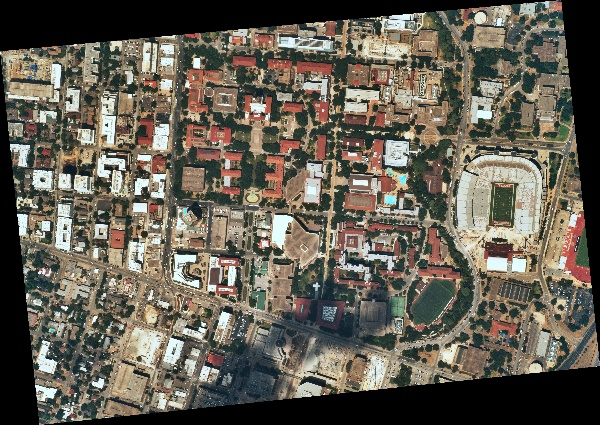

In [1]:
import tempfile
from IPython.display import Image, display
from datetime import date
from nsl.stac import StacRequest, GeometryData, SpatialReferenceData
from nsl.stac import enum, utils
from nsl.stac.client import NSLClient

# the client package stubs out a little bit of the gRPC connection code 
# get a client interface to the gRPC channel. This client singleton is threadsafe
client = NSLClient()

# our area of interest will be the coordinates of the UT Stadium in Austin Texas
# the order of coordinates here is longitude then latitude (x, y). The results of our query 
# will be returned only if they intersect this point geometry we've defined (other geometry 
# types besides points are supported)
# This string format, POINT(float, float) is the well-known-text geometry format:
# https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry
ut_stadium_wkt = "POINT(-97.7323317 30.2830764)"
# GeometryData is a protobuf container for GIS geometry information, the wkid in the spatial 
# reference defines the WGS-84 elispsoid (`wkid=4326`) spatial reference (the latitude longitude 
# spatial reference most commonly used)
geometry_data = GeometryData(wkt=ut_stadium_wkt, sr=SpatialReferenceData(wkid=4326))

# TimestampField is a query field that allows for making sql-like queries for information
# LT_OR_EQ is an enum that means less than or equal to the value in the query field
# Query data from August 25, 2019
time_filter = utils.pb_timestampfield(value=date(2019, 8, 25), rel_type=enum.FieldRelationship.LT_OR_EQ)

# the StacRequest is a protobuf message for making filter queries for data
# This search looks for any type of imagery hosted in the STAC service that intersects the austin 
# capital area of interest and was observed on or after the 1st of August
stac_request = StacRequest(datetime=time_filter, geometry=geometry_data)

# search_one method requests only one item be returned that meets the query filters in the StacRequest 
# the item returned is a StacItem protobuf message. search_one, will only return the most recently 
# observed results that matches the time filter and spatial filter
stac_item = client.search_one(stac_request)

# get the thumbnail asset from the assets map. The other option would be a Geotiff, 
# with asset key 'GEOTIFF_RGB'
asset = utils.get_asset(stac_item, asset_type=enum.AssetType.THUMBNAIL)

with tempfile.TemporaryDirectory() as d:
    filename = utils.download_asset(asset=asset, save_directory=d)
    display(Image(filename=filename))

In the above example, the [StacRequest](https://geo-grpc.github.io/api/#epl.protobuf.StacRequest) holds spatial and temporal query parameters for searching for [StacItems](https://geo-grpc.github.io/api/#epl.protobuf.StacItem). The `client.search_one` method makes requests to the [StacService's](https://geo-grpc.github.io/api/#epl.protobuf.StacService) SearchOne gRPC method. In this case you can see that we've connected to the `eap.nearspacelabs.net` STAC service. In the next section we go into more detail about Protobufs, gRPC, and STAC.

## What are Protobufs, gRPC, and Spatio Temporal Asset Catalogs? 
This python client library is used for connecting to a gRPC enabled STAC service. STAC items and STAC requests are Protocol Buffers (protobuf) instead of traditional JSON.

Never heard of gRPC, Protocol Buffers or STAC? Below are summary blurbs and links for more details about these open source projects.

Definition of STAC from https://stacspec.org/:
> The SpatioTemporal Asset Catalog (STAC) specification provides a common language to describe a range of geospatial information, so it can more easily be indexed and discovered.  A 'spatiotemporal asset' is any file that represents information about the earth captured in a certain space and time.

Definition of gRPC from https://grpc.io
> gRPC is a modern open source high performance RPC framework that can run in any environment. It can efficiently connect services in and across data centers with pluggable support for load balancing, tracing, health checking and authentication. It is also applicable in last mile of distributed computing to connect devices, mobile applications and browsers to backend services.

Definitions of Protocol Buffers (protobuf) from https://developers.google.com/protocol-buffers/
> Protocol buffers are Google's language-neutral, platform-neutral, extensible mechanism for serializing structured data – think XML, but smaller, faster, and simpler. You define how you want your data to be structured once, then you can use special generated source code to easily write and read your structured data to and from a variety of data streams and using a variety of languages.

In other words:
- You can think of Protobuf as strict a data format like xml or JSON + linting, except Protobuf is a compact binary message with strongly typed fields
- gRPC is similar to REST + OpenAPI, except gRPC is an [RPC](https://en.wikipedia.org/wiki/Remote_procedure_call) framework that supports bi-directional streaming
- STAC is a specification that helps remove repeated efforts for searching geospatial datasets (like WFS for specific data types)

### Assets (Images to Download)
In STAC, Assets can be any file type. For our Near Space Labs Swift dataset an asset can be an RGB Geotiff (selected using the `GEOTIFF_RGB` asset key) or an RGB thumbnail (selected using the `THUMBNAIL_RGB` asset key).

* [Example of Downloading a Geotiff](#first-code-example)
* [Example of Downloading a Thumbnail](#downloading)

## Queries

### Simple Query and the Makeup of a StacItem
The easiest query to construct is a `StacRequest` constructor with no variables, and the next simplest, is the case where we know the STAC item `id` that we want to search. If we already know the STAC `id` of an item, we can construct the `StacRequest` as follows:

In [2]:
from nsl.stac.client import NSLClient
from nsl.stac import StacRequest
# get a client interface to the gRPC channel
client = NSLClient()

stac_request = StacRequest(id='20190822T183518Z_746_POM1_ST2_P')

# for this request we might as well use the search one, as STAC ids ought to be unique
stac_item = client.search_one(stac_request)
print(stac_item)

id: "20190822T183518Z_746_POM1_ST2_P"
geometry {
  wkb: "\001\006\000\000\000\001\000\000\000\001\003\000\000\000\001\000\000\000\005\000\000\000J&D\300\310oX\300\354\257\272\223\233I>@\256\311\271\217\270oX\300v\257\331\002FG>@\327-+\221\266nX\300V@\240\t\232G>@\366\032\253~\306nX\300\274\266sf\343I>@J&D\300\310oX\300\354\257\272\223\233I>@"
  sr {
    wkid: 4326
  }
  simple: STRONG_SIMPLE
}
bbox {
  xmin: -97.74662787108642
  ymin: 30.278412035127495
  xmax: -97.7298930093451
  ymax: 30.288626101732675
  sr {
    wkid: 4326
  }
}
properties {
  type_url: "nearspacelabs.com/proto/st.protobuf.SwiftMetadata/st.protobuf.SwiftMetadata"
  value: "\n\03620190822T162258Z_TRAVIS_COUNTY\022 1e39f2910361bd23870c174804e83abe\032\03120200429T233414Z_SWIFTERA \010B\003 \352\005R\03520191202T140547Z_746_ST2_POM1Z\03520190822T183518Z_746_POM1_ST2Z\03520191122T035808Z_746_ST2_POM1Z\03520191122T040127Z_746_ST2_POM1Z\03520191202T140547Z_746_ST2_POM1b\03520190822T183518Z_746_POM1_ST2h\001p\001x\233\024

The above print out for the stac item is quite lengthy. Although `stac_item` is a protobuf object, it's `__str__` method prints out a JSON-like object. You can see in the below example that this `StacItem` contains the following:
- [GeometryData](https://geo-grpc.github.io/api/#epl.protobuf.GeometryData) which is defined with a WGS-84 well-known binary geometry
- [EnvelopeData](https://geo-grpc.github.io/api/#epl.protobuf.EnvelopeData) which is also WGS-84
- [Timestamp](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/timestamp.proto) Google's protobuf unix time format
- [Eo](https://geo-grpc.github.io/api/#epl.protobuf.Eo) for electro-optical sensor details
- [Landsat](https://geo-grpc.github.io/api/#epl.protobuf.Landsat) for Landsat sepcific details
- an array map of [StacItem.AssetsEntry](https://geo-grpc.github.io/api/#epl.protobuf.StacItem.AssetsEntry) with each [Asset](https://geo-grpc.github.io/api/#epl.protobuf.Asset) containing details about [AssetType](https://geo-grpc.github.io/api/#epl.protobuf.AssetType), Electro Optical [Band enums](https://geo-grpc.github.io/api/#epl.protobuf.Eo.Band) (if applicable), and other details for downloading and interpreting data

You may have notice that the [Asset](https://geo-grpc.github.io/api/#epl.protobuf.Asset) in the above python print out has a number of additional parameters not included in the JSON STAC specification. 

### Spatial Queries
The STAC specification has a bounding box `bbox` specification for STAC items. Here we make a STAC request using a bounding box. One slight difference from JSON STAC, is that we define an [EnvelopeData](https://geo-grpc.github.io/api/#epl.protobuf.EnvelopeData) protobuf object. This allows us to use other projections besides WGS84

In [3]:
from nsl.stac import StacRequest, EnvelopeData, SpatialReferenceData
from nsl.stac.client import NSLClient

client = NSLClient()

# define our area of interest bounds using the xmin, ymin, xmax, ymax coordinates of an area on 
# the WGS-84 ellipsoid
neighborhood_box = (-97.7352547645, 30.27526474757116, -97.7195692, 30.28532)
# here we define our envelope_data protobuf with bounds and a WGS-84 (`wkid=4326`) spatial reference
envelope_data = EnvelopeData(xmin=neighborhood_box[0], 
                             ymin=neighborhood_box[1], 
                             xmax=neighborhood_box[2], 
                             ymax=neighborhood_box[3],
                             sr=SpatialReferenceData(wkid=4326))
# Search for data that intersects the bounding box
stac_request = StacRequest(bbox=envelope_data)


for stac_item in client.search(stac_request):
    print("STAC item id: {}".format(stac_item.id))

STAC item id: 20190826T190031Z_776_POM1_ST2_P
STAC item id: 20190826T190001Z_761_POM1_ST2_P
STAC item id: 20190826T185935Z_748_POM1_ST2_P
STAC item id: 20190826T185933Z_747_POM1_ST2_P
STAC item id: 20190826T185916Z_739_POM1_ST2_P
STAC item id: 20190826T185914Z_738_POM1_ST2_P
STAC item id: 20190826T185858Z_730_POM1_ST2_P
STAC item id: 20190826T185856Z_729_POM1_ST2_P
STAC item id: 20190826T185842Z_722_POM1_ST2_P
STAC item id: 20190826T185840Z_721_POM1_ST2_P


Above should be printed the STAC ids of 10 items (10 is the default limit for the service we connected to).

#### Query By GeoJSON

Next we want to try searching by geometry instead of bounding box. We'll use a geojson to define our [GeometryData](https://geo-grpc.github.io/api/#epl.protobuf.GeometryData) protobuf. GeometryData can be defined using geojson, wkt, wkb, or esrishape:

In [4]:
import json
import requests

from nsl.stac import StacRequest, GeometryData, SpatialReferenceData
from nsl.stac.client import NSLClient
client = NSLClient()

# request the geojson foot print of Travis County, Texas
url = "http://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA/TX/Travis.geo.json"
r = requests.get(url)
travis_geojson = json.dumps(r.json()['features'][0]['geometry'])
# create our GeometryData protobuf from geojson string and WGS-84 SpatialReferenceData protobuf
geometry_data = GeometryData(geojson=travis_geojson, 
                             sr=SpatialReferenceData(wkid=4326))
# Search for data that intersects the geojson geometry and limit results 
# to 2 (instead of default of 10)
stac_request = StacRequest(geometry=geometry_data, limit=2)
# collect the ids from STAC items to compare against results from wkt GeometryData
geojson_ids = []

# get a client interface to the gRPC channel
client = NSLClient()
for stac_item in client.search(stac_request):
    print("STAC item id: {}".format(stac_item.id))
    geojson_ids.append(stac_item.id)

STAC item id: 20190829T173549Z_1799_POM1_ST2_P
STAC item id: 20190829T173547Z_1798_POM1_ST2_P


#### Query By WKT

Same geometry as above, but a wkt geometry instead of a geojson:

In [5]:
# Same geometry as above, but a wkt geometry instead of a geojson
travis_wkt = "POLYGON((-97.9736 30.6251, -97.9188 30.6032, -97.9243 30.5703, -97.8695 30.5484, \
              -97.8476 30.4717, -97.7764 30.4279, -97.5793 30.4991, -97.3711 30.4170, \
              -97.4916 30.2089, -97.6505 30.0719, -97.6669 30.0665, -97.7107 30.0226, \
              -98.1708 30.3567, -98.1270 30.4279, -98.0503 30.6251))" 
geometry_data = GeometryData(wkt=travis_wkt, 
                             sr=SpatialReferenceData(wkid=4326))
stac_request = StacRequest(geometry=geometry_data, limit=2)
for stac_item in client.search(stac_request):
    print("STAC item id: {0} from wkt filter intersects result from geojson filter: {1}"
          .format(stac_item.id, stac_item.id in geojson_ids))

STAC item id: 20190829T173549Z_1799_POM1_ST2_P from wkt filter intersects result from geojson filter: True
STAC item id: 20190829T173547Z_1798_POM1_ST2_P from wkt filter intersects result from geojson filter: True


### Temporal Queries
When it comes to Temporal queries there are a few things to note. One is that we are using Google's [Timestamp proto](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/timestamp.proto) to define the temporal aspect of STAC items. This means time is stored with a `int64` for seconds and a `int32` for nanoseconds relative to an epoch at UTC midnight on January 1, 1970.

So when you read the time fields on a [StacItem](https://geo-grpc.github.io/api/#epl.protobuf.StacItem), you'll notice that `datetime`, `observed`, `updated`, and `processed` all use the Timestamp Protobuf object.

When creating a time query filter, we want to use the >, >=, <, <=, ==, != operations and inclusive and exclusive range requests. We do this by using a [TimestampField](https://geo-grpc.github.io/api/#epl.protobuf.TimestampField), where we define the value using the `value` field or the `start`&`stop` fields. And then we define a relationship type using the `rel_type` field and the [FieldRelationship](https://geo-grpc.github.io/api/#epl.protobuf.FieldRelationship) enum values of `EQ`, `LT_OR_EQ`, `GT_OR_EQ`, `LT`, `GT`, `BETWEEN`, `NOT_BETWEEN`, or `NOT_EQ`.

#### Everything After A Secific Date

In [6]:
from datetime import date, datetime, timezone
from nsl.stac.client import NSLClient
from nsl.stac import utils, StacRequest, enum

# make a filter that selects all data on or after August 21st, 2019
value = date(2019, 8, 21)
time_filter = utils.pb_timestampfield(value=value, rel_type=enum.FieldRelationship.GT_OR_EQ)
stac_request = StacRequest(datetime=time_filter, limit=2)

# get a client interface to the gRPC channel
client = NSLClient()
for stac_item in client.search(stac_request):
    print("STAC item date, {0}, is after {1}: {2}".format(
        datetime.fromtimestamp(stac_item.observed.seconds, tz=timezone.utc).isoformat(),
        datetime.fromtimestamp(time_filter.value.seconds, tz=timezone.utc).isoformat(),
        stac_item.observed.seconds > time_filter.start.seconds))

STAC item date, 2019-08-29T17:35:49+00:00, is after 2019-08-21T00:00:00+00:00: True
STAC item date, 2019-08-29T17:35:47+00:00, is after 2019-08-21T00:00:00+00:00: True


The above result shows the datetime of the STAC item, the datetime of the query and a confirmation that they satisfy the query filter. Notice the warning, this is because our date doesn't have a timezone associated with it. By default we assume UTC.

#### Everything Between Two Dates

Now we're going to do a range request and select data between two dates using the `start` and `stop` parameters instead of the `value` parameter:

In [7]:
from datetime import datetime, timezone, timedelta
from nsl.stac.client import NSLClient
from nsl.stac import utils, enum, StacRequest
# Query data from August 1, 2019
start = datetime(2019, 8, 1, 0, 0, 0, tzinfo=timezone.utc)
# ... up until August 10, 2019
stop = start + timedelta(days=9)
time_filter = utils.pb_timestampfield(start=start, end=stop, rel_type=enum.FieldRelationship.BETWEEN)

stac_request = StacRequest(datetime=time_filter, limit=2)

# get a client interface to the gRPC channel
client = NSLClient()
for stac_item in client.search(stac_request):
    print("STAC item date, {0}, is before {1}: {2}".format(
        datetime.fromtimestamp(stac_item.observed.seconds, tz=timezone.utc).isoformat(),
        datetime.fromtimestamp(time_filter.stop.seconds, tz=timezone.utc).isoformat(),
        stac_item.observed.seconds < time_filter.stop.seconds))

STAC item date, 2019-08-06T20:42:53+00:00, is before 2019-08-10T00:00:00+00:00: True
STAC item date, 2019-08-06T20:42:51+00:00, is before 2019-08-10T00:00:00+00:00: True


In the above print out we are returned STAC items that are between the dates of Aug 1 2019 and Aug 10 2019. Also, notice there's no warnings as we defined our utc timezone on the datetime objects.

#### Select Data for One Day

No we'll search for everything on a specific day using a python `datetime.date` for the `value` and `rel_type` set to  use equals (`FieldRelationship.EQ`). Python's `datetime.datetime` is a specific value and if you use it combined with `EQ` the query would insist that the time relationship match down to the second. But since `datetime.date` is only specific down to the day, the filter is created for the entire day. This will check for everything from the start until the end of the 8th of August, specifically in the Austin, Texas timezone (UTC -6).

In [8]:
from datetime import datetime, timezone, timedelta, date
from nsl.stac.client import NSLClient
from nsl.stac import utils, enum, StacRequest
# Query all data for the entire day of August 6, 2019
value = date(2019, 8, 6)
# if you omit this tzinfo from the pb_timestampfield function, the default for tzinfo 
# is assumed to be utc 
texas_utc_offset = timezone(timedelta(hours=-6))
time_filter = utils.pb_timestampfield(rel_type=enum.FieldRelationship.EQ,
                                      value=value,
                                      tzinfo=texas_utc_offset)

stac_request = StacRequest(datetime=time_filter, limit=2)

# get a client interface to the gRPC channel
client = NSLClient()
for stac_item in client.search(stac_request):
    print("STAC item date, {0}, is before {1}: {2}".format(
        datetime.fromtimestamp(stac_item.observed.seconds, tz=timezone.utc).isoformat(),
        datetime.fromtimestamp(time_filter.stop.seconds, tz=texas_utc_offset).isoformat(),
        stac_item.observed.seconds < time_filter.stop.seconds))
    print("STAC item date, {0}, is after {1}: {2}".format(
        datetime.fromtimestamp(stac_item.observed.seconds, tz=timezone.utc).isoformat(),
        datetime.fromtimestamp(time_filter.start.seconds, tz=texas_utc_offset).isoformat(),
        stac_item.observed.seconds > time_filter.start.seconds))

STAC item date, 2019-08-06T20:42:53+00:00, is before 2019-08-06T23:59:59-06:00: True
STAC item date, 2019-08-06T20:42:53+00:00, is after 2019-08-06T00:00:00-06:00: True
STAC item date, 2019-08-06T20:42:51+00:00, is before 2019-08-06T23:59:59-06:00: True
STAC item date, 2019-08-06T20:42:51+00:00, is after 2019-08-06T00:00:00-06:00: True


The above printout demonstrates that the results are between the time ranges of `2019-08-06T00:00:00-06:00` and `2019-08-06T23:59:59-06:00`.

## Downloading
To download an asset use the `bucket` + `object_path` or the `href` fields from the asset, and download the data using the library of your choice. There is also a download utility in the `nsl.stac.utils` module. Downloading from Google Cloud Storage buckets requires having defined your `GOOGLE_APPLICATION_CREDENTIALS` [environment variable](https://cloud.google.com/docs/authentication/getting-started#setting_the_environment_variable). Downloading from AWS/S3 requires having your configuration file or environment variables defined as you would for [boto3](https://boto3.amazonaws.com/v1/documentation/api/1.9.42/guide/quickstart.html#configuration). 

### Thumbnails
To downlad thumbnail assets follow the pattern in the below example:

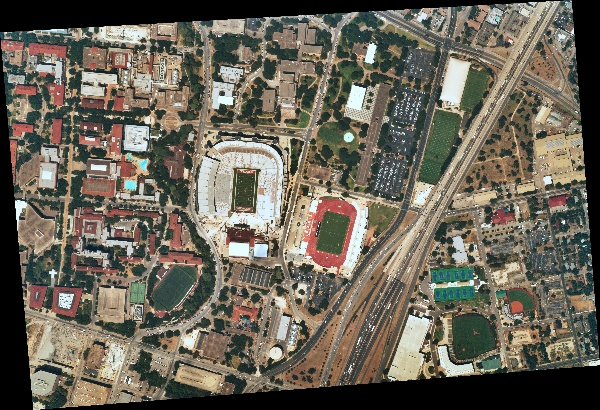

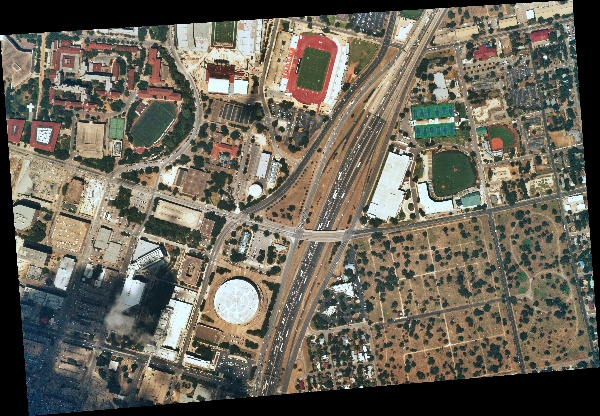

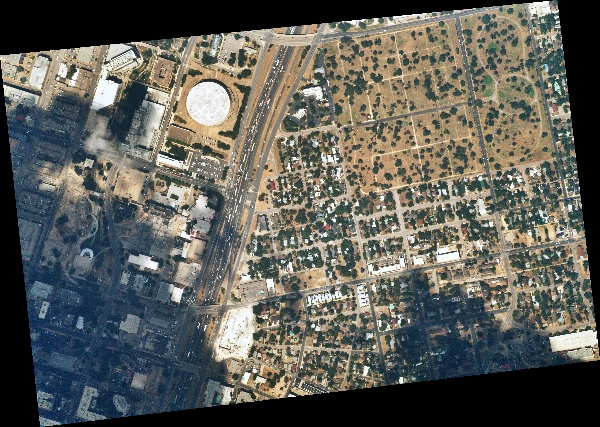

In [9]:
import tempfile
from IPython.display import Image, display

from nsl.stac.client import NSLClient
from nsl.stac import utils, enum, StacRequest, GeometryData, SpatialReferenceData

mlk_blvd_wkt = 'LINESTRING(-97.72842049283962 30.278624772098176,-97.72142529172878 30.2796624743974)'
geometry_data = GeometryData(wkt=mlk_blvd_wkt, 
                             sr=SpatialReferenceData(wkid=4326))
time_filter = utils.pb_timestampfield(value=date(2019, 8, 25), rel_type=enum.FieldRelationship.LT_OR_EQ)
stac_request = StacRequest(geometry=geometry_data,
                           datetime=time_filter,
                           limit=3)

# get a client interface to the gRPC channel
client = NSLClient()

for stac_item in client.search(stac_request):
    # get the thumbnail asset from the assets map
    asset = utils.get_asset(stac_item, asset_type=enum.AssetType.THUMBNAIL)
    # (side-note delete=False in NamedTemporaryFile is only required for windows.)
    with tempfile.NamedTemporaryFile(suffix=".jpg", delete=False) as file_obj:
        utils.download_asset(asset=asset, file_obj=file_obj)
        display(Image(filename=file_obj.name))

### Geotiffs
To download the full geotiff asset follow the pattern in the below example:

In [10]:
import os
import tempfile
from datetime import date
from nsl.stac import StacRequest, GeometryData, SpatialReferenceData, enum
from nsl.stac import utils
from nsl.stac.client import NSLClient

client = NSLClient()

ut_stadium_wkt = "POINT(-97.7323317 30.2830764)"
geometry_data = GeometryData(wkt=ut_stadium_wkt, sr=SpatialReferenceData(wkid=4326))

# Query data from August 1, 2019
time_filter = utils.pb_timestampfield(value=date(2019, 8, 1), rel_type=enum.FieldRelationship.GT_OR_EQ)

stac_request = StacRequest(datetime=time_filter, geometry=geometry_data)

stac_item = client.search_one(stac_request)

# get the Geotiff asset from the assets map
asset = utils.get_asset(stac_item, asset_type=enum.AssetType.GEOTIFF)

with tempfile.TemporaryDirectory() as d:
    file_path = utils.download_asset(asset=asset, save_directory=d)
    print("{0} has {1} bytes".format(os.path.basename(file_path), os.path.getsize(file_path)))

20191202T144608Z_761_ST2_POM1_P.tif has 131626674 bytes


### Handling Deadlines
The `search` method is a gRPC streaming request. It sends a single request to the server and then maintains an open connection to the server, which then pushes results to the client. This means that if you have a long running sub-routine that executes between each iterated result from `search` you may exceed the 15 second timeout. If you have a stac request so large that the results create a memory problem or the blocking behavior limits your application performance, then you will want to use `offset` and `limit` as described in [AdvancedExamples.md](./AdvancedExamples.md#limits-and-offsets).

Otherwise, an easy way to iterate through results without timing-out on long running sub-routines is to capture the `search` results in a `list`.

For example:

In [11]:
import os
import tempfile
from nsl.stac import StacRequest, GeometryData, SpatialReferenceData, enum
from nsl.stac.utils import download_asset, get_asset
from nsl.stac.client import NSLClient


ut_stadium_wkt = "POINT(-97.7323317 30.2830764)"
geometry_data = GeometryData(wkt=ut_stadium_wkt, sr=SpatialReferenceData(wkid=4326))

# limit is set to 2 here, but it would work if you set it to 100 or 1000
stac_request = StacRequest(geometry=geometry_data, limit=2)

# get a client interface to the gRPC channel. This client singleton is threadsafe
client = NSLClient()

# collect all stac items in a list
stac_items = list(client.search(stac_request))

with tempfile.TemporaryDirectory() as d:
    for stac_item in stac_items:
        print("STAC item id: {}".format(stac_item.id))
        asset = get_asset(stac_item, asset_type=enum.AssetType.GEOTIFF)
        filename = download_asset(asset=asset, save_directory=d)
        print("saved {}".format(os.path.basename(filename)))

STAC item id: 20190826T190001Z_761_POM1_ST2_P
saved 20191202T144608Z_761_ST2_POM1_P.tif
STAC item id: 20190826T185933Z_747_POM1_ST2_P
saved 20191202T144613Z_747_ST2_POM1_P.tif


## Differences between gRPC+Protobuf STAC and OpenAPI+JSON STAC
If you are already familiar with STAC, you'll need to know that gRPC + Protobuf STAC is slightly different from the JSON definitions. 

JSON is naturally a flexible format and with linters you can force it to adhere to rules. Protobuf is a strict data format and that required a few differences between the JSON STAC specification and the protobuf specification:

### JSON STAC Compared with Protobuf STAC

#### STAC Item Comparison
For Comparison, here is the [JSON STAC item field summary](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md#item-fields) and the [Protobuf STAC item field summary](https://geo-grpc.github.io/api/#epl.protobuf.StacItem). Below is a table comparing the two:


|  Field Name 	| STAC Protobuf Type                                                                                                       	| STAC JSON Type                                                             	|
|-------------	|--------------------------------------------------------------------------------------------------------------------------	|----------------------------------------------------------------------------	|
| id          	| [string](https://geo-grpc.github.io/api/#string)                                                                         	| string                                                                     	|
| type        	| NA                                                                                                                       	| string                                                                     	|
| geometry    	| [GeometryData](https://geo-grpc.github.io/api/#epl.protobuf.GeometryData)                                                	| [GeoJSON Geometry Object](https://tools.ietf.org/html/rfc7946#section-3.1) 	|
| bbox        	| [EnvelopeData](https://geo-grpc.github.io/api/#epl.protobuf.EnvelopeData)                                                	| [number]                                                                   	|
| properties  	| [google.protobuf.Any](https://developers.google.com/protocol-buffers/docs/proto3#any)                                               	| Properties Object                                                          	|
| links       	| NA                                                                                                                       	| [Link Object]                                                              	|
| assets      	| [StacItem.AssetsEntry](https://geo-grpc.github.io/api/#epl.protobuf.StacItem.AssetsEntry)                                	| Map                                                                        	|
| collection  	| [string](https://geo-grpc.github.io/api/#string)                                                                         	| string                                                                     	|
| title       	| [string](https://geo-grpc.github.io/api/#string)                                                                         	| Inside Properties                                                          	|
| datetime    	| [google.protobuf.Timestamp](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/timestamp.proto) 	| Inside Properties                                                          	|
| observed 	| [google.protobuf.Timestamp](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/timestamp.proto) 	| Inside Properties                                                          	|
| processed   	| [google.protobuf.Timestamp](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/timestamp.proto) 	| Inside Properties                                                          	|
| updated     	| [google.protobuf.Timestamp](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/timestamp.proto) 	| Inside Properties                                                          	|
| duration    	| [google.protobuf.Duration](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/duration.proto)   	| Inside Properties                                                          	|
| eo          	| [Eo](https://geo-grpc.github.io/api/#epl.protobuf.Eo)                                                                    	| Inside Properties                                                          	|
| sar         	| [Sar](https://geo-grpc.github.io/api/#epl.protobuf.Sar)                                                                  	| Inside Properties                                                          	|
| landsat     	| [Landsat](https://geo-grpc.github.io/api/#epl.protobuf.Landsat)                                                          	| Inside Properties                                                          	|


#### Eo Comparison
For Comparison, here is the [JSON STAC Electro Optical field summary](https://github.com/radiantearth/stac-spec/tree/master/extensions/eo#item-fields) and the [Protobuf STAC Electro Optical field summary](https://geo-grpc.github.io/api/#epl.protobuf.Eo). Below is a table comparing the two:

| JSON Field Name  	| JSON Data Type 	| Protobuf Field Name 	| Protobuf Data Type                  	|
|------------------	|----------------	|---------------------	|-------------------------------------	|
| eo:gsd           	| number         	| gsd                 	| [google.protobuf.wrappers.FloatValue](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/wrappers.proto) 	|
| eo:platform      	| string         	| platform            	| [Eo.Platform](https://geo-grpc.github.io/api/#epl.protobuf.Eo.Platform)                         	|
| eo:instrument    	| string         	| instrument          	| [Eo.Instrument](https://geo-grpc.github.io/api/#epl.protobuf.Eo.Instrument)                       	|
| eo:constellation 	| string         	| constellation       	| [Eo.Constellation](https://geo-grpc.github.io/api/#epl.protobuf.Eo.Platform)                    	|
| eo:bands         	| [Band Object](https://github.com/radiantearth/stac-spec/tree/master/extensions/eo#band-object)  	| bands               	| [Eo.Band](https://geo-grpc.github.io/api/#epl.protobuf.Eo.Band)                             	|
| eo:epsg          	| integer        	| epsg                	| uint32                              	|
| eo:cloud_cover   	| number         	| cloud_cover         	| [google.protobuf.wrappers.FloatValue](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/wrappers.proto) 	|
| eo:off_nadir     	| number         	| off_nadir           	| [google.protobuf.wrappers.FloatValue](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/wrappers.proto) 	|
| eo:azimuth       	| number         	| azimuth             	| [google.protobuf.wrappers.FloatValue](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/wrappers.proto) 	|
| eo:sun_azimuth   	| number         	| sun_azimuth         	| [google.protobuf.wrappers.FloatValue](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/wrappers.proto) 	|
| eo:sun_elevation 	| number         	| sun_elevation       	| [google.protobuf.wrappers.FloatValue](https://github.com/protocolbuffers/protobuf/blob/master/src/google/protobuf/wrappers.proto) 	|


### Updating the samples in this README
Use this README.ipynb notebook to update the README.md. Do not directly edit the README.md. It will be overwritten by output from `ipynb2md.py`. `ipynb2md.py` can be downloaded from this [gist](https://gist.github.com/davidraleigh/a24f637ccb018610a87aaacb12281452).

```bash
curl -o ipynb2md.py https://gist.githubusercontent.com/davidraleigh/a24f637ccb018610a87aaacb12281452/raw/20216b01987a2163b37f12b09596b5d322195e79/ipynb2md.py
```

Make your edits to the README.ipynb, in *Kernel->Restart & Run All* to confirm your changes worked, Save and Checkpoint, then run the python script `python ipynb2md.py -i README.ipynb`.
